In [ ]:
import time
import sys
import os
from PIL import Image
import numpy as np
import cv2


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import pandas as pd

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import warnings
warnings.simplefilter("ignore")

## Problem Statement
Image classification is an exciting subclass of computer vision.  The purpose of this project is to examine if a deep learning model can be created to accurately classify brain tumor MRI images into one of four classes: glioma, meningioma, pituitary tumor, or benign. If successful, the model could be used as both a pre-screener and post-screener for the images. Pre-screening could be performed immediately after the image was developed (before being viewed by a doctor or medical professional) and could flag images that need immediate review. Post-screening images (after images are classified by a doctor or medical professional) could ensure that the classification is consistent.

This project will create and evaluate the following three deep learning models to examine if they can be used to classify brain tumor MRI images with high accuracy: 
1. A Convolutional neural network (CNN) model built from scratch using Keras.  
2. A CNN model built on top of the ResNet50 model architecture using the fastai library.
3. A CNN model built on top of the VGG19 model architecture using the fastai library.

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Nov 18 22:31:01 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Dataset used in this project.

---

The data used for this product contains MRI scans from a Brain Tumor Classification dataset on [Kaggle](https://www.kaggle.com/sartajbhuvaji/brain-tumor-classification-mri). The scans contain images with four different labels – glioma tumor, meningioma tumor, pituitary tumor, and no tumor.  The images used in the project can also be downloaded from [google drive](https://drive.google.com/drive/folders/1oLa6T7Bua6nUEbm97Vggz3jQ1hg4ALDx?). 

Let's examine how many images are in each folder for the four classes.

In [ ]:
# Assign training set directory
train_dir = '/content/drive/MyDrive/Brain Cancer Image Classification images/Training'

# Assign testing set directory
test_dir = '/content/drive/MyDrive/Brain Cancer Image Classification images/Testing'

train_labels = os.listdir(train_dir)
print("No. of labels in the Training set: {}".format(len(train_labels)))
print("-----------------")
os.chdir(train_dir)
for label in train_labels:
    print("{}, {} files".format(label, len(os.listdir(train_dir+ '//' +label))))
print('')

test_labels = os.listdir(test_dir)
print("No. of labels in the Testing set: {}".format(len(test_labels)))
print("-----------------")
os.chdir(test_dir)
for label in test_labels:
    print("{}, {} files".format(label, len(os.listdir(test_dir+ '//' +label))))



No. of labels in the Training set: 4
-----------------
pituitary_tumor, 827 files
meningioma_tumor, 822 files
glioma_tumor, 826 files
no_tumor, 395 files

No. of labels in the Testing set: 4
-----------------
pituitary_tumor, 74 files
no_tumor, 105 files
glioma_tumor, 100 files
meningioma_tumor, 115 files


Next, we will plot 10 images from the pituitary tumor training images.




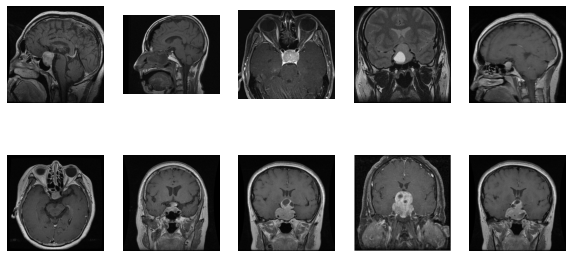

In [ ]:
pituitary_tumors = '/content/drive/MyDrive/Brain Cancer Image Classification images/Training/pituitary_tumor'
sub_class = os.listdir(pituitary_tumors)

fig = plt.figure(figsize=(10,5))
for e in range(len(sub_class[:10])):
    plt.subplot(2,5,e+1)
    img = plt.imread(os.path.join(pituitary_tumors,sub_class[e]))
    plt.imshow(img, cmap=plt.get_cmap('gray'))
    plt.axis('off')

### Data Augmentation.

---
Since we only have around 800 images from each class, we will use data augmentation.  

"_Data augmentation takes the approach of generating more training data from existing training samples, by augmenting the samples via a number of random transformations that yield believable-looking images. The goal is that at training time, your model will never see the exact same picture twice. This helps expose the model to more aspects of the data and generalize better._"

--- (Page 152). 
Chollet François. (2018). Deep learning with python. Manning Publications Co.  

We will use the ImageDataGenerator class from Keras to perform data augmentation. 

In [ ]:
img_datagen = ImageDataGenerator(rescale=1./255,
                                rotation_range=30,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                zoom_range=0.1,
                                validation_split=0.2)
                                
test_datagen = ImageDataGenerator(rescale=1./255)

target_size=(100,100)

train_generator = img_datagen.flow_from_directory(train_dir,
                                                 shuffle=True,
                                                 batch_size=32,
                                                 subset='training',
                                                  class_mode='categorical',
                                                 target_size=target_size)
                                                 
valid_generator = img_datagen.flow_from_directory(train_dir,
                                                 shuffle=True,
                                                 batch_size=16,
                                                 subset='validation',
                                                  class_mode='categorical',
                                                 target_size=target_size)

test_generator = test_datagen.flow_from_directory(test_dir,
                                                  batch_size = 16,
                                                  target_size=target_size,
                                                  class_mode='categorical',
                                                  shuffle=False)

# Create a lablel_map dictionary that we will use for predicting on unseen data
label_map = (train_generator.class_indices)
print('Label mappings:\n')
label_map

Found 2297 images belonging to 4 classes.
Found 573 images belonging to 4 classes.
Found 394 images belonging to 4 classes.
Label mappings:



{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}

## Creating a baseline CNN model using Keras.

---

Next, we will instantiate a Sequential model and add 6 convolutional and maxpooling layers. We will also add three dropout layers to avoid overfitting.  

In [ ]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=(100,100,3), activation='relu', padding = 'same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding = 'same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding = 'same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding = 'same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding = 'same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding = 'same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.4))

model.add(Dense(len(label_map)))
model.add(Activation('softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 100, 100, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 50, 50, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 50, 50, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 25, 25, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 25, 25, 64)        36928     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 12, 12, 64)      

To avoid overfitting, we will use the EarlyStopping class to monitor the validation accuracy and stop training the model if the accuracy does not improve after more than 4 epochs (patience=4).



In [ ]:
callbacks_list = [EarlyStopping( monitor='accuracy', patience=4),
                  ModelCheckpoint( filepath='/content/drive/MyDrive/train results/models/keras_brain_cancer_classification_model.h5',
                                  monitor='val_accuracy', save_best_only=True, ) ]


Next, we compile the model using the adam optimizer and the categoical_crossentropy loss function since this is a multi-class classification problem.

In [ ]:
model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [ ]:
history = model.fit(train_generator, validation_data=valid_generator,
                   steps_per_epoch=train_generator.n//train_generator.batch_size,
                   validation_steps=valid_generator.n//valid_generator.batch_size,
                    callbacks=[callbacks_list],
                    epochs=50)

Epoch 1/50
71/71 [==============================] - 22s 297ms/step - loss: 1.3446 - accuracy: 0.3245 - val_loss: 1.3547 - val_accuracy: 0.4143
Epoch 2/50
71/71 [==============================] - 21s 293ms/step - loss: 1.2200 - accuracy: 0.4499 - val_loss: 1.2425 - val_accuracy: 0.4232
Epoch 3/50
71/71 [==============================] - 21s 296ms/step - loss: 1.0545 - accuracy: 0.5439 - val_loss: 1.1220 - val_accuracy: 0.5000
Epoch 4/50
71/71 [==============================] - 21s 292ms/step - loss: 0.8891 - accuracy: 0.6313 - val_loss: 1.1238 - val_accuracy: 0.5214
Epoch 5/50
71/71 [==============================] - 21s 293ms/step - loss: 0.7600 - accuracy: 0.6706 - val_loss: 0.9801 - val_accuracy: 0.5268
Epoch 6/50
71/71 [==============================] - 21s 293ms/step - loss: 0.6963 - accuracy: 0.7051 - val_loss: 0.9179 - val_accuracy: 0.5875
Epoch 7/50
71/71 [==============================] - 20s 289ms/step - loss: 0.6868 - accuracy: 0.7020 - val_loss: 1.0286 - val_accuracy: 0.5250

### Plotting baseline model training and validation curves.

---
Next, we will plot the training and validation accuracy and loss curves.

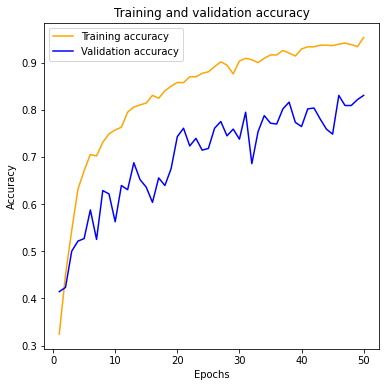

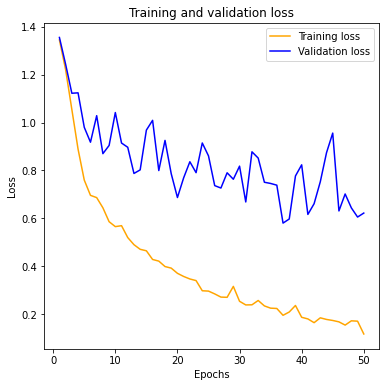

In [ ]:
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs = range(1, len(training_accuracy) + 1)
plt.figure(figsize=(6,6))
plt.plot(epochs, training_accuracy, 'orange', label='Training accuracy')
plt.plot(epochs, validation_accuracy, 'b', label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure(figsize=(6,6))

plt.plot(epochs, training_loss, 'orange', label='Training loss')
plt.plot(epochs, validation_loss, 'b', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()


From the above training and validation curves, we can see that the validation scores are worse than the training scores across all epochs. Next, we will make predictions with the best performing model that was saved during early stopping.

### Predicting on Test Images
We will use the test_generator along with the predict_generator method to calculate the accuracy and confustion matrix for the test images.


In [ ]:
# Reset the test_generator
test_generator.reset()
# Calculate the array of prediction probabilities
Y_pred = model.predict_generator(test_generator)
# Get the actual class values
classes = test_generator.classes[test_generator.index_array]
# Calculate the percentage of correct predictions
y_pred = np.argmax(Y_pred, axis=1)

print('The accuracy on the test set = {}'.format(round(sum(y_pred==classes)/len(y_pred)*100,3))+'%')

The accuracy on the test set = 56.091%


From above, we can see that the accuracy on the test set is only around 56%, which is not a good result, especially for diagnosing serious health conditions. Next we will further investigate the results by plotting the confustion matrix and calculating the classificatoin report metrics.

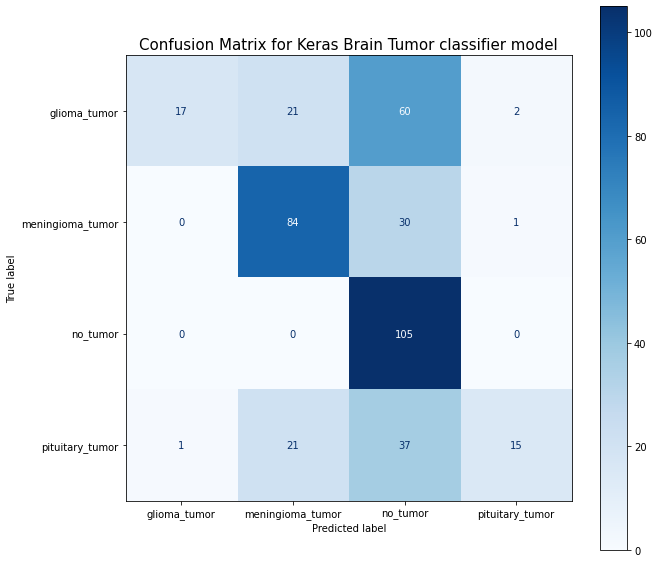

In [ ]:
# Set the figure size
plt.rcParams["figure.figsize"] = (10,10)

# Create a list of the target_names in the order they appear in the label map
target_names =['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

# Calculate the confusion matrix
cm = confusion_matrix(test_generator.classes[test_generator.index_array],y_pred, labels=[0,1,2,3])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=target_names)

# Plot the confustion matrix
disp.plot(cmap = plt.get_cmap('Blues'),values_format = '.0f')
plt.title('Confusion Matrix for Keras Brain Tumor classifier model',fontsize=15)
plt.show()

In [ ]:
print(classification_report(test_generator.classes[test_generator.index_array], y_pred, target_names=target_names))

                  precision    recall  f1-score   support

    glioma_tumor       0.94      0.17      0.29       100
meningioma_tumor       0.67      0.73      0.70       115
        no_tumor       0.45      1.00      0.62       105
 pituitary_tumor       0.83      0.20      0.33        74

        accuracy                           0.56       394
       macro avg       0.72      0.53      0.48       394
    weighted avg       0.71      0.56      0.50       394



From the above classification report, we can see that the model performs poorly on unseen test images. This makes the model unusable, so we will explore creating a new model on top of the ResNet50 model.

## Using Fastai to build a model on top of the ResNet50 model architecture.

---
Next, we will use the fastai library to build a model on top of the pretrained ResNet50 model. First we import the fastai library and setup the data using the ImageDataBunch.from_folder function. This function automatically infers the class names. We can also perform image augmentation if necessary, setup the validation set, image size, and batch size.

In [ ]:
from fastai.vision import *
from fastai.widgets import *

data = ImageDataBunch.from_folder(
    train_dir,
    valid_pct=0.2,
    ds_tfms=get_transforms(do_flip=False),
    size=100,
    num_workers=8,
    bs=64
)

data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (2296 items)
x: ImageList
Image (3, 100, 100),Image (3, 100, 100),Image (3, 100, 100),Image (3, 100, 100),Image (3, 100, 100)
y: CategoryList
pituitary_tumor,pituitary_tumor,pituitary_tumor,pituitary_tumor,pituitary_tumor
Path: /content/drive/MyDrive/Brain Cancer Image Classification images/Training;

Valid: LabelList (574 items)
x: ImageList
Image (3, 100, 100),Image (3, 100, 100),Image (3, 100, 100),Image (3, 100, 100),Image (3, 100, 100)
y: CategoryList
meningioma_tumor,meningioma_tumor,meningioma_tumor,pituitary_tumor,meningioma_tumor
Path: /content/drive/MyDrive/Brain Cancer Image Classification images/Training;

Test: None

Next, we will use the show_batch function to show some of the images.

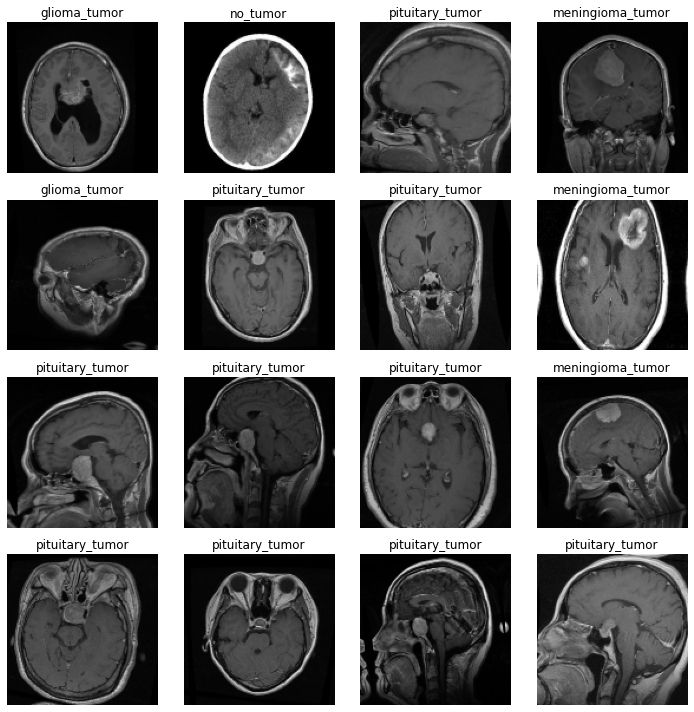

In [ ]:
data.show_batch(rows=4, figsize=(10,10))

### Downloading and using the ResNet50 model.

---
Next, we will load the resnet50 model, and train the model on the dataset for 5 epochs.

In [ ]:
learn = cnn_learner(data, models.resnet50, metrics=[accuracy,Precision(),Recall()])

In [ ]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy,precision,recall,time
0,1.200690,1.273827,0.747387,0.751917,0.746916,00:18
1,0.900256,0.495746,0.836237,0.842674,0.843887,00:18
2,0.702255,0.380960,0.865854,0.867317,0.873183,00:18
3,0.532213,0.343129,0.872822,0.877494,0.871160,00:18
4,0.423109,0.326024,0.886760,0.888562,0.889605,00:18


### Adding layers on top of the ResNet50 model architecture.

---
From above, we can see that we achieved almost 89% accuracy without any tuning of the model.  
Next, we will unfreeze the top layers of ResNet50, and find an optimal learning rate. 

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.29E-06
Min loss divided by 10: 2.75E-07


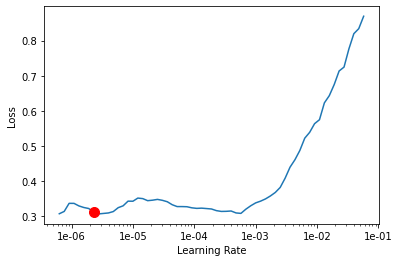

In [ ]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

### Adjusting the learning rate for the ResNet50 model.

---
Looking at the graph, we will vary the learning rate between 1e-05 to 1e-04. (the early layers will have a maximum lr of 1e-05 and the deepest layers will have 1e-04 as their max_lr). We will use the slice function and to vary the learning rate and fit the model for 5 epochs.

In [ ]:
learn.fit_one_cycle(5, slice(1e-05,1e-04))

epoch,train_loss,valid_loss,accuracy,precision,recall,time
0,0.324063,0.282326,0.891986,0.893291,0.892856,00:18
1,0.275256,0.301869,0.893728,0.902953,0.896491,00:18
2,0.225029,0.217936,0.919861,0.925896,0.920777,00:18
3,0.189489,0.211462,0.926829,0.931718,0.929767,00:18
4,0.163508,0.207558,0.925087,0.932309,0.926123,00:18


We can see from above that the accuracy tops out at 92.6%. We will save the model and download the VGG19 model to see if we can improve performance with a new model.

In [ ]:
learn.save("/content/drive/MyDrive/train results/models/fastai_brain_cancer_resnet_model")

### Downloading and using the VGG19 model.
---
Next, we will load the VGG19 model, and train the model on the dataset for 5 epochs.


In [ ]:
learn_vgg = cnn_learner(data, models.vgg19_bn, metrics=[accuracy,Precision(),Recall()])

In [ ]:
learn_vgg.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy,precision,recall,time
0,1.385684,0.717501,0.745645,0.750546,0.776748,00:18
1,0.989610,0.556637,0.815331,0.808905,0.825736,00:18
2,0.739526,0.423170,0.827526,0.822773,0.828582,00:18
3,0.579030,0.378837,0.853659,0.848346,0.849457,00:18
4,0.495401,0.369469,0.858885,0.853701,0.855297,00:18


We can see from above that the accuracy is only around 86% without any tuning of the model.  
Next, we will unfreeze the top layers of VGG19, and find an optimal learning rate. 

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.09E-05
Min loss divided by 10: 6.92E-05


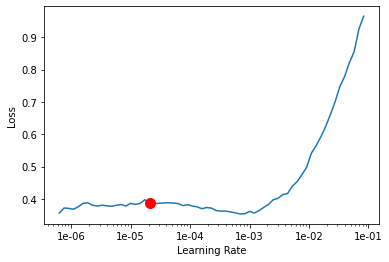

In [ ]:
learn_vgg.unfreeze()
learn_vgg.lr_find()
learn_vgg.recorder.plot(suggestion=True)

### Adjusting the learning rate for the VGG19 model.

---
Looking at the graph, we will vary the learning rate between 1e-05 to 1e-03. (the early layers will have a maximum lr of 1e-05 and the deepest layers will have 1e-03 as their max_lr). We will use the slice function and to vary the learning rate and fit the model for 10 epochs.

In [ ]:
learn_vgg.fit_one_cycle(10, slice(1e-05,1e-03))

epoch,train_loss,valid_loss,accuracy,precision,recall,time
0,0.391056,0.322775,0.878049,0.873783,0.885118,00:19
1,0.310011,0.263938,0.902439,0.902425,0.898541,00:19
2,0.238178,0.200687,0.933798,0.934855,0.932146,00:19
3,0.181757,0.211982,0.926829,0.925205,0.932556,00:19
4,0.129686,0.236787,0.933798,0.930981,0.939618,00:19
5,0.095988,0.128574,0.959930,0.961018,0.960546,00:19
6,0.063498,0.130134,0.965157,0.962028,0.964917,00:19
7,0.043327,0.121494,0.968641,0.963369,0.968276,00:18
8,0.032519,0.120551,0.968641,0.964608,0.968539,00:19
9,0.024042,0.121943,0.965157,0.961734,0.965362,00:18


### Plotting the confusion matrix of the final fastai VGG19 model.
---

The model accuracy increased to a high of 96.8%, which is an 11% improvement over using the VGG19 model with no tuning.  
Next, we will save the model.

In [ ]:
learn_vgg.save("/content/drive/MyDrive/train results/models/fastai_brain_cancer_vgg19_model")

Fastai allows you to view the images with the highest loss values by using the DatasetFormatter().from_toplosses function. This function would enable a domain expert to review the labels and potentially correct the labels. We will not change any labels.

### Plotting images with the highest losses.

---
Next, we can plot the images that had the highest loss values to examine them.

In [ ]:
interp = ClassificationInterpretation.from_learner(learn_vgg)

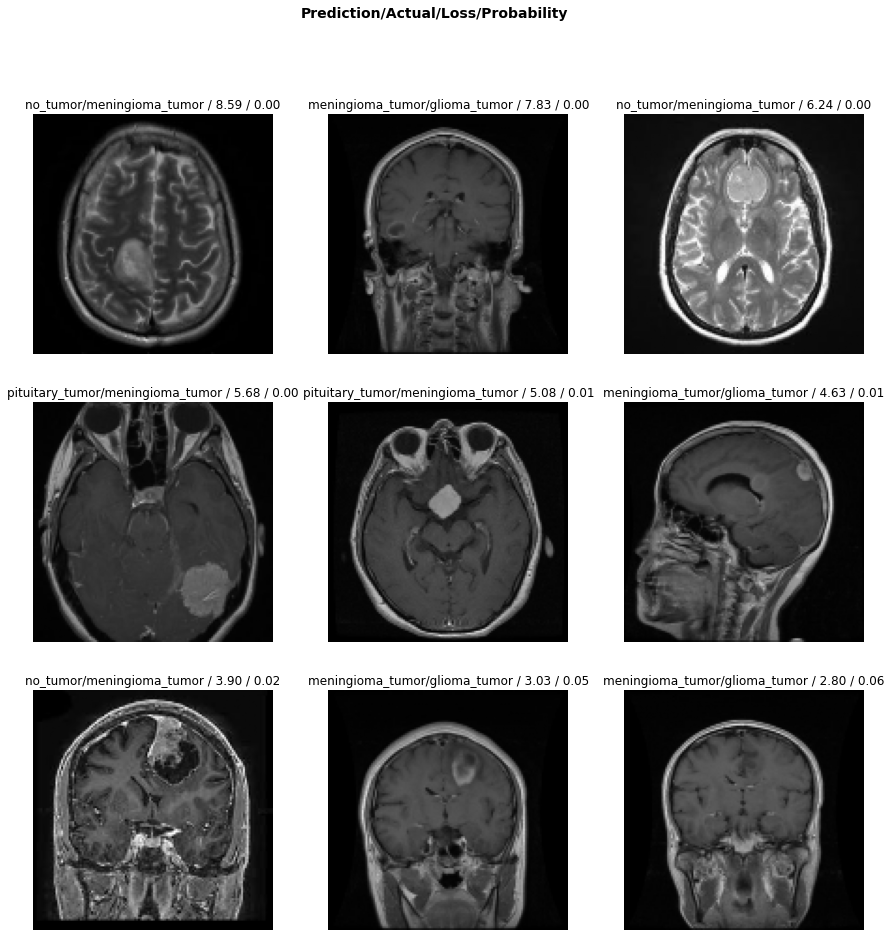

In [ ]:
interp.plot_top_losses(9, figsize=(15,15))

Using the above images, a domain expert could examine them to see if they can identify if they were truly incorrect classifications, or if the images were mislabeled. If the images were incorrectly labeled, then fastai has a function called from_toplosses() function that allows images with the highest loss values to be manually re-labeled.

### Plotting the confusion matrix of the final fastai model.

---

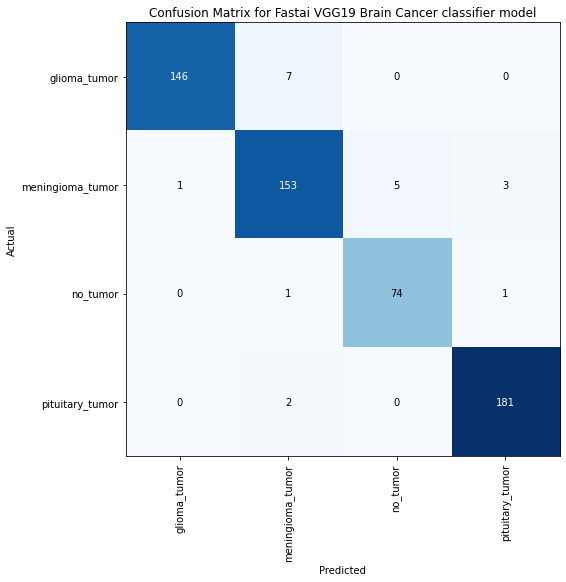

In [ ]:
interp.plot_confusion_matrix(figsize=(8,8),
                             title='Confusion Matrix for Fastai VGG19 Brain Cancer classifier model')

### Conclusions.

---
  
To recap, we first built a CNN from scratch in Keras and achieved a validation accuracy of 83.1%. Then, we used the fastai library to build a baseline model on top of the ResNet50 model and achieved a validation accuracy of 88.6%. We then tuned the model and the validation accuracy increased to 92.6%.  

Next, we built a baseline model on top of the VGG19 model and achieved a validation accuracy of 85.8%. We then tuned the model and the validation accuracy increased to 96.8%.   

Overall, I am happy the increases in accuracy of the different models. I was impressed by how easy it is to build models in fastai on top of pretrained models. Fastai is a powerful low-code library that uses PyTorch to easily build deep learning models. Fastai enables you to use transfer learning to easily build CNN models using pretrained models.  

### Limitations.

---
As with any use case for machine learning in medicine, we need to remember that a model’s prediction is no substitute for the diagnosis of a trained medical professional. Therefore, machine learning should only be used in conjunction with the diagnosis of a medical professional, rather than as a unilateral method of diagnosis. 